In [1]:
    import warnings
    warnings.simplefilter("ignore")
    

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, MultiOutputMixin
from collections import Counter
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#import keras

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [3]:
df = pd.read_excel('auto_insurance_claim.xlsx',index_col='ID')

In [4]:
df.head()

,target,Gender,EngineHP,credit_history,Years_Experience,annual_claims,Marital_Status,Vehical_type,Miles_driven_annually,size_of_family,Age_bucket,EngineHP_bucket,Years_Experience_bucket,Miles_driven_annually_bucket,credit_history_bucket,State
ID,,,,,,,,,,,,,,,,
1,1,F,522,656,1,0,Married,Car,14749.0,5,<18,>350,<3,<15k,Fair,IL
2,1,F,691,704,16,0,Married,Car,15389.0,6,28-34,>350,15-30,15k-25k,Good,NJ
3,1,M,133,691,15,0,Married,Van,9956.0,3,>40,90-160,15-30,<15k,Good,CT
4,1,M,146,720,9,0,Married,Van,77323.0,3,18-27,90-160,9-14',>25k,Good,CT
5,1,M,128,771,33,1,Married,Van,14183.0,4,>40,90-160,>30,<15k,Very Good,WY


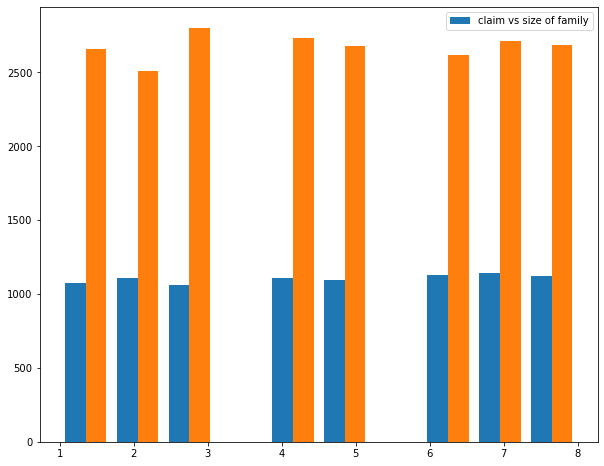

In [5]:
idx_1 = np.where(df['target'] == 0)
idx_2 = np.where(df['target'] == 1)
d_np = df.iloc[idx_1]['size_of_family']
d_p = df.iloc[idx_2]['size_of_family']
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist([d_np, d_p],label="claim vs size of family")
plt.legend()

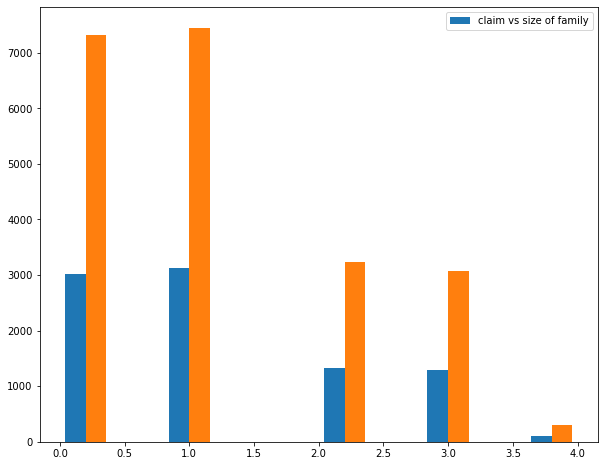

In [6]:
idx_1 = np.where(df['target'] == 0)
idx_2 = np.where(df['target'] == 1)
d_np = df.iloc[idx_1]['annual_claims']
d_p = df.iloc[idx_2]['annual_claims']
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist([d_np, d_p],label="claim vs size of family")
plt.legend()

In [7]:
df['annual_claims'].value_counts()

1    10569
0    10334
2     4562
3     4366
4      409
Name: annual_claims, dtype: int64

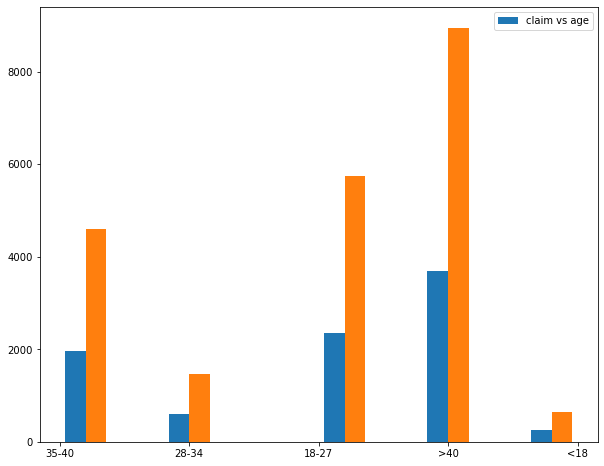

In [8]:
idx_1 = np.where(df['target'] == 0)
idx_2 = np.where(df['target'] == 1)
d_np = df.iloc[idx_1]['Age_bucket']
d_p = df.iloc[idx_2]['Age_bucket']
plt.figure(figsize=[10,8])
n, bins, patches = plt.hist([d_np, d_p],label="claim vs age")
plt.legend()

In [9]:
df = df[df['Miles_driven_annually'].notna()]

df['Gender'] = df['Gender'].replace(['F','M'],[0,1])
df['Marital_Status'] = df['Marital_Status'].replace(['Single','Married'],[0,1])

a = pd.get_dummies(df['Vehical_type']).astype(np.int64)
#a.astype(np.float64)
df = pd.concat((df,a),axis=1)


df['credit_per_person'] = round(df['credit_history']/df['size_of_family'],-1)

age_bucket_mapping = {'<18':1, '28-34':3, '>40':5, '18-27':2, '35-40':4}
df['Age_bucket'] = df['Age_bucket'].map(age_bucket_mapping) 
df['Age_bucket'] = df['Age_bucket'].replace([2],3)
df['Age_bucket'] = df['Age_bucket'].replace([4,5],5)
df['Age_bucket'] = StandardScaler().fit_transform(np.array(df['Age_bucket']).reshape(-1,1))

df = df.drop(columns=['State','Vehical_type'])

df['annual_claims'] = df['annual_claims'].replace([2,3],5)
df['annual_claims'] = df['annual_claims'].replace([4],50)
df['annual_claims'] = MinMaxScaler().fit_transform(np.array(df['annual_claims']).reshape(-1,1))

In [10]:
df_RS = df.copy()
df_SS = df.copy()

In [11]:
df_SS['EngineHP_SS'] = StandardScaler().fit_transform(np.array(df['EngineHP']).reshape(-1,1))
df_RS['EngineHP_RS'] = RobustScaler(quantile_range=(15,85)).fit_transform(np.array(df['EngineHP']).reshape(-1,1))

df_SS['size_of_family_SS'] = StandardScaler().fit_transform(np.array(df['size_of_family']).reshape(-1,1))
df_RS['size_of_family_RS'] = RobustScaler(quantile_range=(15,85)).fit_transform(np.array(df['size_of_family']).reshape(-1,1))

df_SS['credit_history_SS'] = StandardScaler().fit_transform(np.array(df['credit_history']).reshape(-1,1))
df_RS['credit_history_RS'] = RobustScaler(quantile_range=(15,85)).fit_transform(np.array(df['credit_history']).reshape(-1,1))

df_SS['Years_Experience_SS'] = StandardScaler().fit_transform(np.array(df['Years_Experience']).reshape(-1,1))
df_RS['Years_Experience_RS'] = RobustScaler(quantile_range=(15,85)).fit_transform(np.array(df['Years_Experience']).reshape(-1,1))

df_SS['Miles_driven_annually_SS'] = StandardScaler().fit_transform(np.array(df['Miles_driven_annually']).reshape(-1,1))
df_RS['Miles_driven_annually_RS'] = RobustScaler(quantile_range=(15,85)).fit_transform(np.array(df['Miles_driven_annually']).reshape(-1,1))

df_SS['credit_per_person_SS'] = StandardScaler().fit_transform(np.array(df['credit_per_person']).reshape(-1,1))
df_RS['credit_per_person_RS'] = RobustScaler(quantile_range=(15,85)).fit_transform(np.array(df['credit_per_person']).reshape(-1,1))

#####################################buckets########################
df_RSb = df_RS.copy()
df_SSb = df_SS.copy()

In [12]:
engine_bucket_mapping = {'>350':4, '90-160':2, '<90':1, '161-350':3}
df['EngineHP_bucket'] = df['EngineHP_bucket'].map(engine_bucket_mapping)

years_exp_bucket_mapping = {"<3":1, "3-8'":2, "9-14'":3, "15-30":4, ">30":5}
df["Years_Experience_bucket"] = df['Years_Experience_bucket'].map(years_exp_bucket_mapping)

miles_bucket_mapping = {'<15k':1, '15k-25k':2, '>25k':3}
df['Miles_driven_annually_bucket'] = df['Miles_driven_annually_bucket'].map(miles_bucket_mapping)

credit_bucket_mapping = {'Fair':2, 'Good':3, 'Very Good':4, 'Exceptional':5, 'Very Poor':1}
df['credit_history_bucket'] = df['credit_history_bucket'].map(credit_bucket_mapping)

In [13]:

df_SSb['EngineHP_SS_b'] = StandardScaler().fit_transform(np.array(df['EngineHP_bucket']).reshape(-1,1))
df_RSb['EngineHP_RS_b'] = RobustScaler(quantile_range=(15,85)).fit_transform(np.array(df['EngineHP_bucket']).reshape(-1,1))

df_SSb['Years_Experience_SS_b'] = StandardScaler().fit_transform(np.array(df['Years_Experience_bucket']).reshape(-1,1))
df_RSb['Years_Experience_RS_b'] = RobustScaler(quantile_range=(15,85)).fit_transform(np.array(df['Years_Experience_bucket']).reshape(-1,1))

df_SSb['Miles_driven_annually_SS_b'] = StandardScaler().fit_transform(np.array(df['Miles_driven_annually_bucket']).reshape(-1,1))
df_RSb['Miles_driven_annually_RS_b'] = RobustScaler(quantile_range=(15,85)).fit_transform(np.array(df['Miles_driven_annually_bucket']).reshape(-1,1))

df_SSb['credit_history_SS_b'] = StandardScaler().fit_transform(np.array(df['credit_history_bucket']).reshape(-1,1))
df_RSb['credit_history_RS_b'] = RobustScaler(quantile_range=(15,85)).fit_transform(np.array(df['credit_history_bucket']).reshape(-1,1))

In [14]:
for i in ['EngineHP','size_of_family','credit_history','Years_Experience','Miles_driven_annually','credit_per_person']:
    print("Value counts range for",i,"_SS",df_SS[i+'_SS'].min(),df_SS[i+'_SS'].max())

Value counts range for EngineHP _SS -0.8810820727655874 6.108238044315591
Value counts range for size_of_family _SS -1.540387488894285 1.5213478539230734
Value counts range for credit_history _SS -3.7649536391444696 1.6030639435329122
Value counts range for Years_Experience _SS -1.2391062999475266 2.704461848288033
Value counts range for Miles_driven_annually _SS -0.7105524312124264 4.719883942060373
Value counts range for credit_per_person _SS -0.9934095585256588 3.216841136171517


In [15]:
for i in ['EngineHP','credit_history','Years_Experience','Miles_driven_annually','credit_history']:
    print("Value counts range for",i,"_SS",df_SSb[i+'_SS_b'].min(),df_SSb[i+'_SS_b'].max())

Value counts range for EngineHP _SS -1.6905464457206396 1.8898243846800504
Value counts range for credit_history _SS -1.9832234406654954 2.01756468566359
Value counts range for Years_Experience _SS -1.6464571104141252 1.758580521452879
Value counts range for Miles_driven_annually _SS -0.8058968551453345 1.4023759378170286
Value counts range for credit_history _SS -1.9832234406654954 2.01756468566359


In [16]:
for i in ['EngineHP','size_of_family','credit_history','Years_Experience','Miles_driven_annually','credit_per_person']:
    print("Value counts range for",i,"_RS",df_RS[i+'_RS'].min(),df_RS[i+'_RS'].max())

Value counts range for EngineHP _RS -0.2364341085271318 3.3488372093023258
Value counts range for size_of_family _RS -0.8 0.6
Value counts range for credit_history _RS -2.354651162790698 0.8430232558139535
Value counts range for Years_Experience _RS -0.45 1.5
Value counts range for Miles_driven_annually _RS -0.5326816276057864 6.41435020890193
Value counts range for credit_per_person _RS -0.3793103448275862 2.413793103448276


In [17]:
for i in ['EngineHP','credit_history','Years_Experience','Miles_driven_annually','credit_history']:
    print("Value counts range for",i,"_SS",df_RSb[i+'_RS_b'].min(),df_RSb[i+'_RS_b'].max())

Value counts range for EngineHP _SS -0.5 1.0
Value counts range for credit_history _SS -1.0 1.0
Value counts range for Years_Experience _SS -1.0 1.0
Value counts range for Miles_driven_annually _SS 0.0 1.0
Value counts range for credit_history _SS -1.0 1.0


In [18]:
drop1 = ['EngineHP','credit_history','Years_Experience','Miles_driven_annually','credit_per_person','EngineHP_bucket','credit_history_bucket','Years_Experience_bucket','Miles_driven_annually_bucket']
df_RS = df_RS.drop(columns=drop1)
df_SS = df_SS.drop(columns=drop1)
df_RSb = df_RSb.drop(columns=drop1)
df_SSb = df_SSb.drop(columns=drop1)

In [20]:
features_df = df.drop(columns=['target']) 
target_df = df['target']

features_df_RS = df_RS.drop(columns=['target']) 
target_df_RS = df_RS['target']

features_df_SS = df_SS.drop(columns=['target']) 
target_df_SS = df_SS['target']

features_df_RSb = df_RSb.drop(columns=['target']) 
target_df_RSb = df_RSb['target']

features_df_SSb = df_SSb.drop(columns=['target']) 
target_df_SSb = df_SSb['target']

In [21]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(features_df_RS)
cluster = kmeans.predict(features_df_RS)
cluster_distance = kmeans.transform(features_df_RS)
#features_df_RS['cluster'] = cluster
features_df_RS['a'] = cluster_distance[:,0]
features_df_RS['b'] = cluster_distance[:,1]
features_df_RS['c'] = cluster_distance[:,2]
features_df_RS['d'] = cluster_distance[:,3]
features_df_RS['e'] = cluster_distance[:,4]

In [22]:
Xtrain_df, Xtest_df, Ytrain_df, Ytest_df = train_test_split(features_df, target_df, test_size = 0.20, random_state =42)

Xtrain_df_RS, Xtest_df_RS, Ytrain_df_RS, Ytest_df_RS = train_test_split(features_df_RS, target_df_RS, test_size = 0.20, random_state =42)

Xtrain_df_SS, Xtest_df_SS, Ytrain_df_SS, Ytest_df_SS = train_test_split(features_df_SS, target_df_SS, test_size = 0.20, random_state =42)

Xtrain_df_RSb, Xtest_df_RSb, Ytrain_df_RSb, Ytest_df_RSb = train_test_split(features_df_RSb, target_df_RSb, test_size = 0.20, random_state =42)

Xtrain_df_SSb, Xtest_df_SSb, Ytrain_df_SSb, Ytest_df_SSb = train_test_split(features_df_SSb, target_df_SSb, test_size = 0.20, random_state =42)

In [23]:
def mae(y_true, y_pred):
    return 100 - 100*np.mean(abs(y_true - y_pred))

baseline_guess = (np.median(Ytrain_df))

print("The baseline guess is ",baseline_guess)
print("The baseline performance on the train set: accuracy = %0.4f" % (mae(Ytrain_df,baseline_guess)))

The baseline guess is  1.0
The baseline performance on the train set: accuracy = 70.6388


In [24]:
def mae(y_true, y_pred):
    return 100 - 100*np.mean(abs(y_true - y_pred))

baseline_guess = (np.median(Ytest_df))

print("The baseline guess is ",baseline_guess)
print("The baseline performance on the test set: accuracy = %0.4f" % (mae(Ytest_df,baseline_guess)))

The baseline guess is  1.0
The baseline performance on the test set: accuracy = 71.2089


In [25]:
for i,j in [(Xtrain_df, Ytrain_df), (Xtrain_df_RS, Ytrain_df_RS), (Xtrain_df_SS, Ytrain_df_SS), (Xtrain_df_RSb, Ytrain_df_RSb), (Xtrain_df_SSb, Ytrain_df_SSb)]:
    print("\n\n\nTraining starts")
    
    random_forest = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=42)
    random_forest.fit(i,j);
    acc_random_forest = round(random_forest.score(i,j)*100, 2)
    print("---------------------Random Forest trained---------------------")


    logreg = LogisticRegression(random_state=42)
    logreg.fit(i,j);
    acc_log = round(logreg.score(i,j)*100,2)
    print("---------------------Logistic Regression trained---------------------")


    knn = KNeighborsClassifier(n_neighbors=7,)
    knn.fit(i,j);
    acc_knn = round(knn.score(i,j)*100,2)
    print("---------------------KNN trained---------------------")

    
    gaussian = GaussianNB()
    gaussian.fit(i,j);
    acc_gaussian = round(gaussian.score(i,j)*100,2)
    print("---------------------Naive Bayes trained---------------------")
    
    
    linear_svc = LinearSVC(C=500,random_state=42)
    linear_svc.fit(i,j);
    acc_linear_svc = round(linear_svc.score(i,j)*100,2)
    print("---------------------Support Vector Classifier trained---------------------")
    

    decision_tree = DecisionTreeClassifier(max_depth=10, random_state=42)
    decision_tree.fit(i,j);
    acc_decision_tree = round(decision_tree.score(i,j)*100,2)
    print("---------------------Decision Tree trained---------------------")

    
    results = pd.DataFrame(
    {
        'Model': ['SVM', 'KNN', "Log Reg", "Random Forest", "Naive Bayes",  "Decision Tree"],
        'Score': [acc_linear_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_decision_tree]
    })

    results_df = results.sort_values(by='Score',ascending=False)
    results_df = results_df.set_index('Score')
    print(results_df)




Training starts
---------------------Random Forest trained---------------------
---------------------Logistic Regression trained---------------------
---------------------KNN trained---------------------
---------------------Naive Bayes trained---------------------
---------------------Support Vector Classifier trained---------------------
---------------------Decision Tree trained---------------------
               Model
Score               
72.78            KNN
71.37  Decision Tree
70.92  Random Forest
70.64            SVM
70.64        Log Reg
70.64    Naive Bayes



Training starts
---------------------Random Forest trained---------------------
---------------------Logistic Regression trained---------------------
---------------------KNN trained---------------------
---------------------Naive Bayes trained---------------------
---------------------Support Vector Classifier trained---------------------
---------------------Decision Tree trained---------------------
              

In [122]:
param_grid = {
    'max_depth' : [5,15,30],
    'criterion' : ['gini','entropy'],
    'n_estimators' : [50,100,200],
    'max_features': ['auto',8,10],
    'max_leaf_nodes': [100,300,700],
    'min_samples_split' : [50,100,200]
}

rf = RandomForestClassifier(n_estimators=200,max_depth = 10,criterion='entropy', max_features='auto',
                            max_leaf_nodes = 200, random_state=1,n_jobs=-1,oob_score=True)
clf = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs=-1)

clf.fit(Xtrain_df_RS,Ytrain_df_RS)
#clf.bestparams_

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=200,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=-1,
                                              oob_score=True, random_state=1,
                                   

In [124]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 8,
 'max_leaf_nodes': 700,
 'min_samples_split': 50,
 'n_estimators': 100}

In [139]:
final_model = RandomForestClassifier(n_estimators=100,max_depth = 15,criterion='gini', max_features=8,
                            max_leaf_nodes = 700, min_samples_split=50, random_state=42,n_jobs=-1,oob_score=True)
final_model.fit(Xtrain_df_RS,Ytrain_df_RS)

Y_pred = final_model.predict(Xtest_df_RS)
print("Train Accuracy: ",round(final_model.score(Xtrain_df_RS,Ytrain_df_RS)*100,2))

print("Test Accuracy: ",100*accuracy_score(Ytest_df_RS, Y_pred))



Train Accuracy:  70.8
Test Accuracy:  71.1096411443691


In [135]:
param_grid = {
    'weights' : ['uniform','distance'],
    'p' : [1,2,5],
    'n_neighbors': [3,7,15]
}

knn = KNeighborsClassifier(n_neighbors=7)

clf = GridSearchCV(estimator = knn, param_grid = param_grid, n_jobs=-1)

clf.fit(Xtrain_df_RS,Ytrain_df_RS)


clf.best_params_

{'n_neighbors': 15, 'p': 5, 'weights': 'uniform'}

In [138]:
final_model = KNeighborsClassifier(n_neighbors=20,p=5,weights='uniform')
final_model.fit(Xtrain_df_RS,Ytrain_df_RS)

Y_pred = final_model.predict(Xtest_df_RS)
print("Train Accuracy: ",round(final_model.score(Xtrain_df_RS,Ytrain_df_RS)*100,2))

print("Test Accuracy: ",100*accuracy_score(Ytest_df_RS, Y_pred))

Train Accuracy:  70.97
Test Accuracy:  69.45592855961634


In [130]:
(tn, fp, fn, tp) = confusion_matrix(Ytest_df_RS, Y_pred).ravel()
print("Classification Report :",classification_report(Ytest_df_RS,Y_pred))
print("True Positive :",tp)
print("True Negative :",tn)
print("False Positive :",fp)
print("False Negative :",fn)

print("Specificity :", tn/(tn+fp))
print("Sensitivity :", tp/(tp+fn))

Classification Report :               precision    recall  f1-score   support

           0       0.20      0.00      0.00      1741
           1       0.71      1.00      0.83      4306

    accuracy                           0.71      6047
   macro avg       0.46      0.50      0.42      6047
weighted avg       0.56      0.71      0.59      6047

True Positive : 4298
True Negative : 2
False Positive : 1739
False Negative : 8
Specificity : 0.0011487650775416428
Sensitivity : 0.9981421272642824


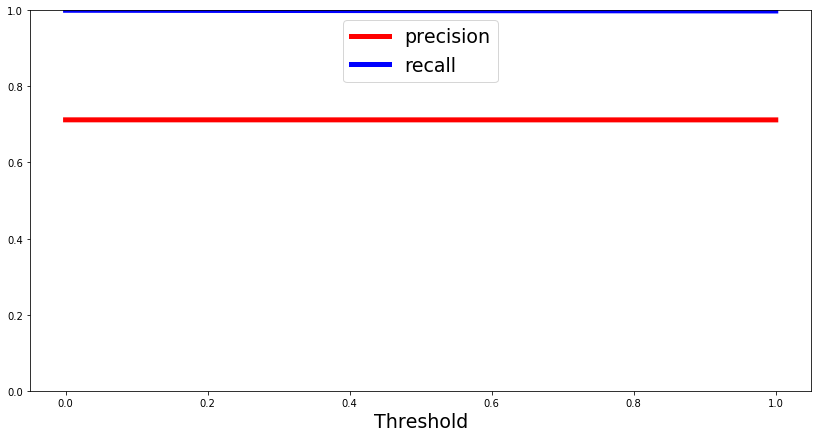

In [131]:
prec, rec, thres = precision_recall_curve(Ytest_df_RS, Y_pred)

def plot_precision_recall(prec, recall, thres):
    plt.plot(thres, prec[:-1],"r-",label="precision",linewidth=5)
    plt.plot(thres, rec[:-1],"b",label="recall",linewidth=5)
    plt.xlabel("Threshold", fontsize=19)
    plt.legend(loc=9,fontsize=19)
    plt.ylim([0,1])
plt.figure(figsize=(14,7))
plot_precision_recall(prec, rec, thres)

plt.show()

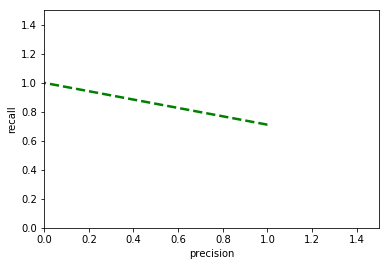

In [140]:
def plot_precision_vs_recall(prec, rec):
    plt.plot(rec, prec, "g--", linewidth=2.5)
    plt.ylabel("recall")
    plt.xlabel("precision")
    plt.axis([0,1.5,0,1.5])
plt.figure()
plot_precision_vs_recall(prec,rec)
plt.show()

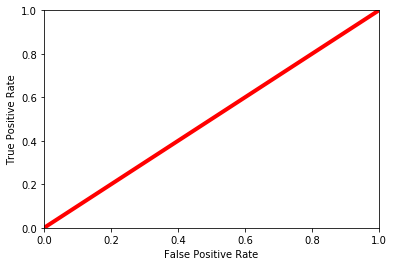

In [142]:
fpr, tpr, thresh = roc_curve(Ytest_df_RS, Y_pred)
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1],'r',linewidth=4)
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plt.figure()
plot_roc_curve(fpr, tpr)
plt.show()